
# <center> Семинар 11: линейная регрессия </center>



Сегодня мы будем работать с датасетом __bikes_rent.csv__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

In [6]:
# добавляем библиотеки
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков
%matplotlib inline

Подгрузим наши данные и посмотрим на них:

In [7]:
df = pd.read_csv('bikes_rent.csv')
df.head( )

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


__Описание пееменных:__

* `season`  1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`  0 - 2011, 1 - 2012
* `mnth`  от 1 до 12
* `holiday`  0 - нет праздника, 1 - есть праздник
* `weekday`  от 0 до 6
* `workingday`  0 - нерабочий день, 1 - рабочий день
* `weathersit`  оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`  температура в Цельсиях
* `atemp`  температура по ощущениям в Цельсиях
* `hum`  влажность
* `windspeed(mph)`  скорость ветра в милях в час
* `windspeed(ms)`  скорость ветра в метрах в секунду
* `cnt`  количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

##  Изучаем данные

Давайте посмотрим, есть ли пропущенные значения:

In [8]:
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed(mph)    0
windspeed(ms)     0
cnt               0
dtype: int64

Можно видеть, что пропусков нет. Нам повезло!

Для удобства давайте разделим категориальные и числовые переменные (так как для них будет разная предобработка и разные методы визуализации, а также отделим целевую переменную:

In [9]:
# категориальные переменные 
var_cat = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# непрерывные переменные
var_real = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

target = 'cnt'

Построим гистограмму для целевого признака. Это необходимо для того, чтобы оценить, необходимо ли какое-то преобразование (например, логарифмическое)

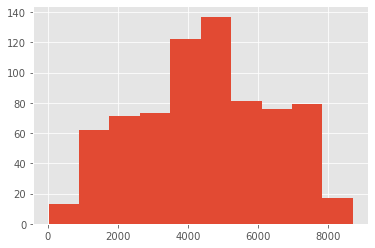

In [10]:
df[target].hist();

Теперь давайте изучим, какие зависимости целевой переменной от предикторов мы можем наблюдать. Визуализируем зависимости для удобства:

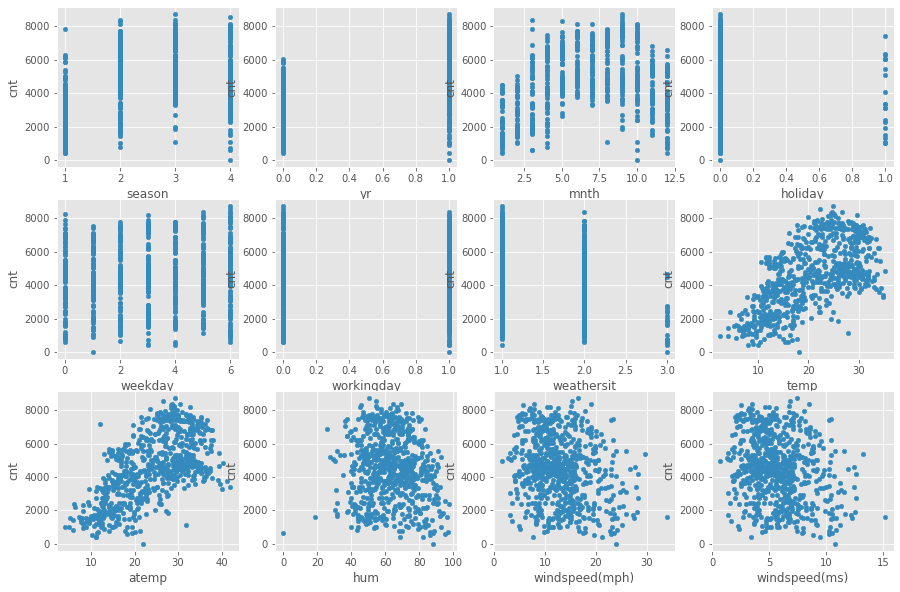

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

## Обработка количественных признаков

Давайте посмотрим, есть ли выбросы среди числовых переменных

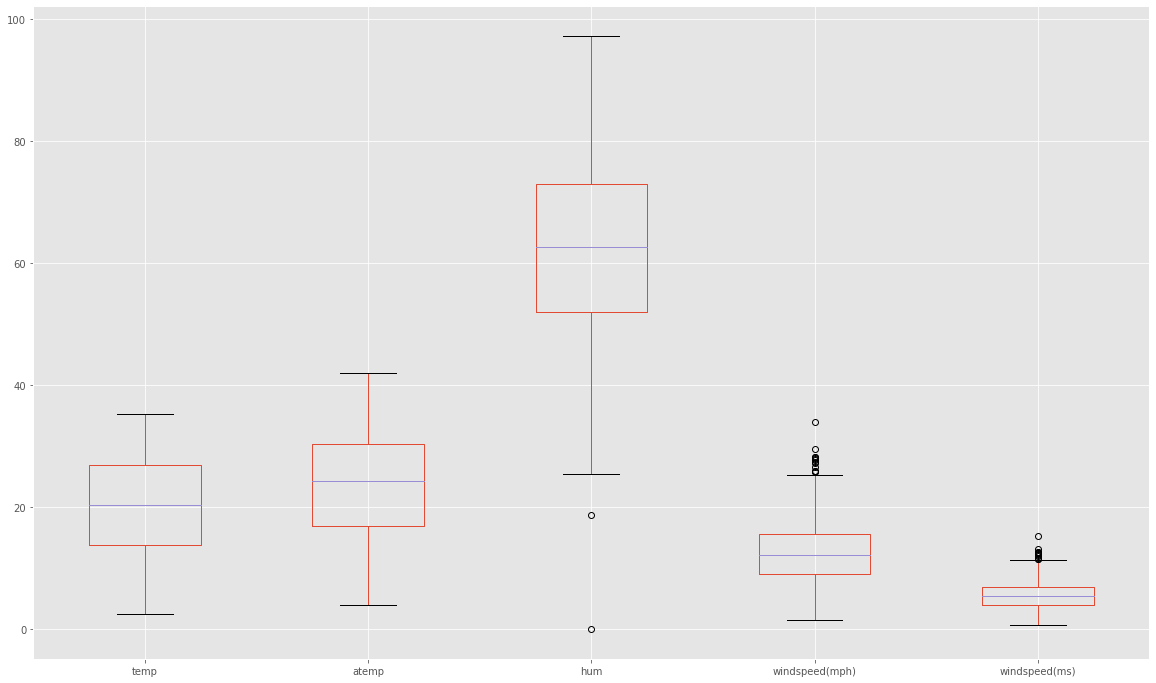

In [12]:
df[var_real].boxplot(figsize=(20, 12));

Можно видеть выбросы в признаках, отражающих уровень влажности и скорость ветра. 

## Исследование на наличие мультиколлинеарности

Мультиколлинеарность — сильная корреляционная связь между признаками, отбираемыми для обучения. 
Сильно скоррелированные признаки сообщают для модели одну и ту же информацию. Поэтому для обучения не нужно использовать их все. Часть из них необходимо удалить из набора данных. 

Для того, чтобы изучить, наблюдается ли в данных мультиколлинеарность, необходимо построить матрицу корреляций. Строить мы ее будем, разумеется, только для числовых признаков.

In [8]:
df[var_real+[target]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


Можно также представить результаты в визуальном виде:

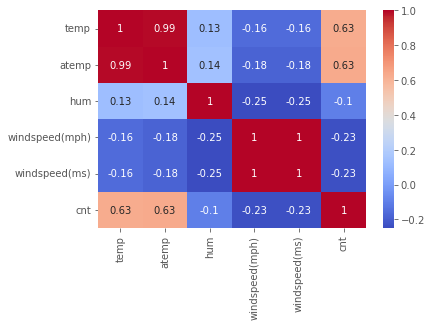

In [9]:
sns.heatmap(df[var_real+[target]].corr(), cmap='coolwarm', annot = True);

Из набора нескольких коррелирующих признаков следует оставлять один. Поэтому оставим среди числовых признаков только те, которые слабо коррелируют между собой. То есть, надо удалить один из признаков temp и atemp. Удалим реальную температуру и оставим atemp.

In [13]:
df.drop('temp', axis=1, inplace=True)
df.drop('windspeed(mph)', axis=1, inplace=True)

In [17]:
df.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.342876,0.205445,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.046106,-0.110651,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.227459,0.222204,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.032507,-0.015937,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.007537,-0.052232,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052182,0.024327,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.121583,0.591045,0.039511,-0.297391
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,1.000000,0.139988,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.139988,1.000000,-0.248489,-0.100659
windspeed(ms),-0.229046,-0.011817,-0.207502,0.006292,0.014282,-0.018796,0.039511,-0.183643,-0.248489,1.000000,-0.234545


## Обработка категориальных признаков 

Посмотрим на распределения значений для категориальных признаков

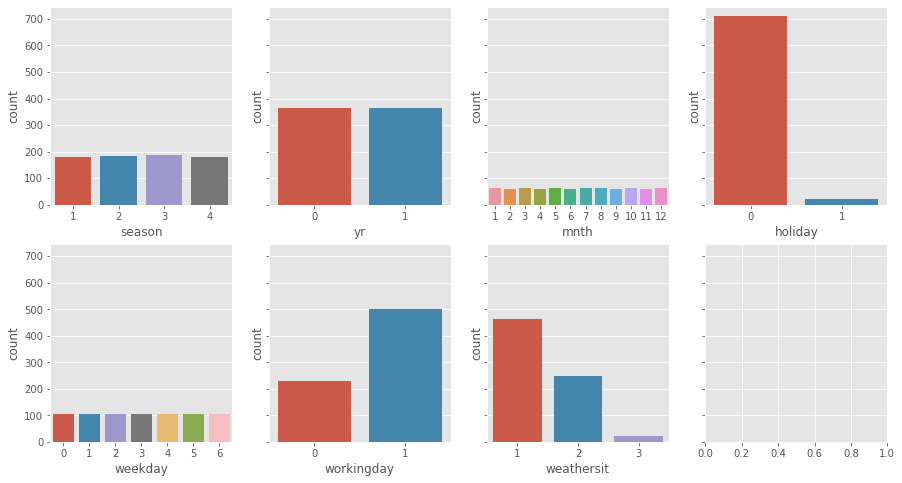

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8), sharey=True)

for i in range(len(var_cat)):
    sns.countplot(x=var_cat[i], data=df, ax=axes[i // 4, i % 4])

Как эти признаки мешают просто взять и запустить LinearRegression? Дело в том, что некоторых из этих признаков содержат числа, которые не несут содержательного смысла (например, день недели). Значит, их нужно перекодировать.

Для этого нам понадобятся дамми-переменные.
Как ввести дамми-переменную в модель?
Как правило, это переменная, которая принимает только два
возможных значения: 0 или 1 (дихотомическая, бинарная).
При этом 0 означает отсутствие признака у данного
объекта; 1 – наличие признака. 

Например, для дня недели это будет выглядеть следующим образом:

<a href="https://imgbb.com/"><img src="https://i.ibb.co/pWv0VcP/sadxa.jpg" alt="sadxa" border="0"></a>

Давайте сделаем это OHE-кодирование. Сколько свежих OHE-признаков у нас появилось? 

In [19]:
df[var_cat] = df[var_cat].astype(str)  # чтобы все категории стали object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         731 non-null    object 
 1   yr             731 non-null    object 
 2   mnth           731 non-null    object 
 3   holiday        731 non-null    object 
 4   weekday        731 non-null    object 
 5   workingday     731 non-null    object 
 6   weathersit     731 non-null    object 
 7   atemp          731 non-null    float64
 8   hum            731 non-null    float64
 9   windspeed(ms)  731 non-null    float64
 10  cnt            731 non-null    int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 62.9+ KB


In [22]:
df.shape

(731, 11)

In [20]:
dff = pd.get_dummies(df, drop_first=True, dummy_na=False)
dff.head()

,atemp,hum,windspeed(ms),cnt,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,18.18125,80.5833,4.805490,985,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,17.68695,69.6087,7.443949,801,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,9.47025,43.7273,7.437060,1349,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,10.60610,59.0435,4.800998,1562,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,11.46350,43.6957,5.597810,1600,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [21]:
dff.shape

(731, 29)

## Создание новых признаков 

__[1]__   Некоторые из наших переменных могут вносить в спрос на велосипеды нелинейный вклад. Например, температура. 

Сначала, когда температура возрастает, люди выходят кататься охотнее, а потом, когда становится жарко, спрос резко падает. Так возникает параболическая зависимость. 

Давайте создадим для каждой действительной переменной из данных дополнительную переменную: её квадрат. 

In [25]:
#var_real.remove('temp')
var_real.remove('windspeed(mph)')

In [26]:
for var in var_real:
    dff[var + '_sq'] = dff[var]**2

In [27]:
dff

,atemp,hum,windspeed(ms),cnt,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,atemp_sq,hum_sq,windspeed(ms)_sq
0,18.18125,80.5833,4.805490,985,0,0,0,0,0,0,...,0,0,0,1,0,1,0,330.557852,6493.668239,23.092738
1,17.68695,69.6087,7.443949,801,0,0,0,0,0,0,...,0,0,0,0,0,1,0,312.828200,4845.371116,55.412371
2,9.47025,43.7273,7.437060,1349,0,0,0,0,0,0,...,0,0,0,0,1,0,0,89.685635,1912.076765,55.309860
3,10.60610,59.0435,4.800998,1562,0,0,0,0,0,0,...,0,0,0,0,1,0,0,112.489357,3486.134892,23.049580
4,11.46350,43.6957,5.597810,1600,0,0,0,0,0,0,...,1,0,0,0,1,0,0,131.411832,1909.314198,31.335472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,11.33210,65.2917,10.486773,2114,0,0,0,1,0,0,...,0,1,0,0,1,1,0,128.416490,4263.006089,109.972406
727,12.75230,59.0000,4.656485,3095,0,0,0,1,0,0,...,0,0,1,0,1,1,0,162.621155,3481.000000,21.682853
728,12.12000,75.2917,3.725374,1341,0,0,0,1,0,0,...,0,0,0,1,0,1,0,146.894400,5668.840089,13.878409
729,11.58500,48.3333,10.505372,1796,0,0,0,1,0,0,...,0,0,0,0,0,0,0,134.212225,2336.107889,110.362849


Еще давайте создадим бинарный признак, который будет отвечать за очень хорошую по всем параметрам погоду.

In [17]:
# Будем считать, что температура между 15 и 25 - хорошо 
# Скорость ветра от 4 до 8 - не слишком сильный, но и не духота
# weathersit = 1, то есть день ясный и чистый

In [28]:
super_nice_day = (15 <= dff['atemp']) & (dff['atemp'] <= 25)& \
    (4 <= dff['windspeed(ms)'])& (dff['windspeed(ms)'] <= 8)& \
    (dff['weathersit_2'] == 0)&(dff['weathersit_3'] == 0)

sum(super_nice_day) # сколько таких дней 

78

In [30]:
super_nice_day

0      False
1      False
2      False
3      False
4      False
       ...  
726    False
727    False
728    False
729    False
730    False
Length: 731, dtype: bool

In [29]:
dff.shape[0] # всего дней

731

In [31]:
dff['super_nice_day'] = super_nice_day

Теперь определим целевую переменую:

In [32]:
dff

,atemp,hum,windspeed(ms),cnt,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,...,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,atemp_sq,hum_sq,windspeed(ms)_sq,super_nice_day
0,18.18125,80.5833,4.805490,985,0,0,0,0,0,0,...,0,0,1,0,1,0,330.557852,6493.668239,23.092738,False
1,17.68695,69.6087,7.443949,801,0,0,0,0,0,0,...,0,0,0,0,1,0,312.828200,4845.371116,55.412371,False
2,9.47025,43.7273,7.437060,1349,0,0,0,0,0,0,...,0,0,0,1,0,0,89.685635,1912.076765,55.309860,False
3,10.60610,59.0435,4.800998,1562,0,0,0,0,0,0,...,0,0,0,1,0,0,112.489357,3486.134892,23.049580,False
4,11.46350,43.6957,5.597810,1600,0,0,0,0,0,0,...,0,0,0,1,0,0,131.411832,1909.314198,31.335472,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,11.33210,65.2917,10.486773,2114,0,0,0,1,0,0,...,1,0,0,1,1,0,128.416490,4263.006089,109.972406,False
727,12.75230,59.0000,4.656485,3095,0,0,0,1,0,0,...,0,1,0,1,1,0,162.621155,3481.000000,21.682853,False
728,12.12000,75.2917,3.725374,1341,0,0,0,1,0,0,...,0,0,1,0,1,0,146.894400,5668.840089,13.878409,False
729,11.58500,48.3333,10.505372,1796,0,0,0,1,0,0,...,0,0,0,0,0,0,134.212225,2336.107889,110.362849,False


In [33]:
y = dff['cnt'] # то, что прогнозируем 

А в качестве предикторов (признаков) возьмем все, кроме целевой переменной:

In [34]:
X = dff.drop('cnt', axis=1)

Посмотрим, какие признаки у нас будут отвечать за предсказание аренды:

In [35]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atemp             731 non-null    float64
 1   hum               731 non-null    float64
 2   windspeed(ms)     731 non-null    float64
 3   season_2          731 non-null    uint8  
 4   season_3          731 non-null    uint8  
 5   season_4          731 non-null    uint8  
 6   yr_1              731 non-null    uint8  
 7   mnth_10           731 non-null    uint8  
 8   mnth_11           731 non-null    uint8  
 9   mnth_12           731 non-null    uint8  
 10  mnth_2            731 non-null    uint8  
 11  mnth_3            731 non-null    uint8  
 12  mnth_4            731 non-null    uint8  
 13  mnth_5            731 non-null    uint8  
 14  mnth_6            731 non-null    uint8  
 15  mnth_7            731 non-null    uint8  
 16  mnth_8            731 non-null    uint8  
 1

In [ ]:
# Удаляем выбросы из humidity и windspeed(ms)

In [49]:
lower_hum = np.median(dff['hum']) - 1.5 * np.std(dff['hum'])
upper_hum = np.median(dff['hum']) + 1.5 * np.std(dff['hum'])

dff = dff[(dff.hum >= lower_hum) & (dff.hum <= upper_hum)]

In [50]:
lower_hum2 = np.median(dff['hum_sq']) - 1.5 * np.std(dff['hum_sq'])
upper_hum2 = np.median(dff['hum_sq']) + 1.5 * np.std(dff['hum_sq'])

dff = dff[(dff.hum_sq >= lower_hum2) & (dff.hum_sq <= upper_hum2)]

In [51]:
lower_ws = np.median(dff['windspeed(ms)']) - 1.5 * np.std(dff['windspeed(ms)'])
upper_ws= np.median(dff['windspeed(ms)']) + 1.5 * np.std(dff['windspeed(ms)'])

dff = dff[(dff['windspeed(ms)'] >= lower_ws) & (dff['windspeed(ms)'] <= upper_ws)]

In [52]:
lower_ws2 = np.median(dff['windspeed(ms)_sq']) - 1.5 * np.std(dff['windspeed(ms)_sq'])
upper_ws2 = np.median(dff['windspeed(ms)_sq']) + 1.5 * np.std(dff['windspeed(ms)_sq'])

dff = dff[(dff['windspeed(ms)_sq'] >= lower_ws2) & (dff['windspeed(ms)_sq'] <= upper_ws2)]

In [53]:
dff.shape

(431, 33)

## Время регрессии

Сначала давайте сделаем наивный прогноз:

In [54]:
y_mean = np.mean(y)                     # посчитали среднее 
y_pred_naive = np.ones(len(y)) * y_mean  # спрогнозировали им продажи
y_pred_naive[:5]

array([4504.34883721, 4504.34883721, 4504.34883721, 4504.34883721,
       4504.34883721])

In [56]:
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [57]:
rmse(y, y_pred_naive)

1935.8859561152221

 Теперь будем использовать для предсказания линейную регрессию:

In [58]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model = LinearRegression()

# Обучили модель 
model.fit(X, y)

# Сделали прогнозы 
y_pred = model.predict(X)

Оценим качество:

In [59]:
rmse(y, y_pred)

696.493477269047

Ура, качество стало лучше!

## Валидация

На самом деле, мы не можем оценивать качество модели на тех же данных, на которых мы ее обучали. Нам важно, чтобы модель могла давать хорошие прогнозы для новых данных. Поэтому мы будем делить наши данные на две части: тренировочную и тестовую выборку. На тренировочной будем обучать модель, а на тестовой делать предсказания и оценивать, насколько они точные.

In [60]:
from sklearn.model_selection import train_test_split  # функция для деления 

np.random.seed(123)
# делим в пропорции 70 к 30
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size = 0.3)

In [61]:
# Обучили модель на тренировочной выборке 
model.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred = model.predict(X_test)

In [62]:
rmse(y_test, y_pred)

698.8614636017612

In [63]:
# Функция для того, чтобы на одной картинке смотреть те графики с прогнозами.
def plot_yreal_ypred(y_test, y_train, y_test_hat, y_train_hat):
    """
        Рисует картинку для прогнозов регрессии 
    """
    
    margin = 0.1 # отступ на границах
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_train, y_train_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    train_min = min(y_train)
    train_max = max(y_train)
    plt.xlim(train_min - margin, train_max + margin)
    plt.ylim(train_min - margin, train_max + margin)
    plt.plot([-10000, 10000], [-10000, 10000])
    plt.title('Train set', fontsize=20)

    plt.subplot(122)
    plt.scatter(y_test, y_test_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    test_min = min(y_test)
    test_max = max(y_test)
    plt.xlim(test_min - margin, test_max + margin)
    plt.ylim(test_min - margin, test_max + margin)
    plt.plot([-10000, 10000], [-10000, 10000])
    plt.title('Test set', fontsize=20)
    pass

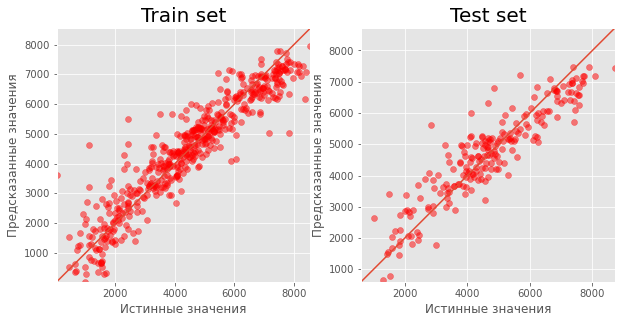

In [64]:
plot_yreal_ypred(y_test, y_train, y_pred, model.predict(X_train))

Теперь давайте посмотрим коэффициенты, которые получились у предикторов:

In [65]:
features = list(df.columns)  

In [66]:
for co, fe in zip(model.coef_, features):
    print(fe, round(co, 2))

season 344.25
yr 61.64
mnth 61.22
holiday 778.59
weekday 984.29
workingday 1575.9
weathersit 1863.37
atemp -54.41
hum -597.97
windspeed(ms) -457.63
cnt -107.03


Также можем оценить коэффициент детерминации:

In [67]:
from sklearn.metrics import r2_score

In [68]:
print(r2_score(y_test, y_pred))

0.8438948263929736


Отлично, наша модель объясняет 83% разброса. Это неплохой результат!

## Кросс-валидация

In [69]:
# X1 X2 X3 X4 X5

# 1:
# О: X1 X2 X3 X4 -> X5

# 2
# О: X2 X3 X4 X5 -> X1

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores 

array([0.79859192, 0.85344026, 0.84359273, 0.85595087, 0.86791851])

In [71]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.80088111, 0.84694774, 0.90335594, 0.83544537, 0.85896888])

In [72]:
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-688653.41410406, -583552.61886373, -597035.44720169,
       -652420.92973136, -520324.84183138])

In [74]:
?RFE

In [73]:
from sklearn.feature_selection import RFE
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

hyper_params = [{'n_features_to_select': list(range(1, 14))}]



lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True)      


model_cv.fit(X_train, y_train)       

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2')

In [75]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.026074,0.007228,0.001503,0.000480,1,{'n_features_to_select': 1},0.029321,0.026902,0.033096,-0.009480,...,0.026446,0.020083,13,0.373309,0.083358,0.081023,0.073830,0.077382,0.137780,0.117809
1,0.015096,0.000727,0.000991,0.000048,2,{'n_features_to_select': 2},0.061449,0.223616,0.171985,0.410409,...,0.259582,0.141540,12,0.420194,0.210060,0.223028,0.333750,0.341782,0.305763,0.078967
2,0.013562,0.000323,0.000951,0.000024,3,{'n_features_to_select': 3},0.122059,0.315954,0.263570,0.464049,...,0.321822,0.125189,11,0.468897,0.301993,0.313608,0.370068,0.389668,0.368847,0.059943
3,0.018954,0.009642,0.001039,0.000124,4,{'n_features_to_select': 4},0.156493,0.507675,0.448068,0.541465,...,0.429059,0.139556,10,0.520864,0.438082,0.452713,0.414065,0.434729,0.452091,0.036534
4,0.019121,0.002784,0.001396,0.000418,5,{'n_features_to_select': 5},0.272901,0.704289,0.784367,0.566569,...,0.570041,0.175820,9,0.573012,0.729463,0.709645,0.466578,0.484869,0.592713,0.109820
5,0.016621,0.001335,0.001316,0.000235,6,{'n_features_to_select': 6},0.344141,0.713728,0.795324,0.597604,...,0.604812,0.153072,8,0.635727,0.737214,0.714360,0.532653,0.545142,0.633019,0.083995
6,0.017181,0.001428,0.001260,0.000038,7,{'n_features_to_select': 7},0.353730,0.712997,0.811796,0.652742,...,0.630370,0.152885,7,0.689284,0.746793,0.725685,0.592221,0.606007,0.671998,0.062441
7,0.013018,0.001259,0.001073,0.000150,8,{'n_features_to_select': 8},0.463623,0.728805,0.825054,0.640175,...,0.658524,0.119624,6,0.702715,0.753364,0.732052,0.686126,0.626448,0.700141,0.043554
8,0.012191,0.000633,0.000992,0.000056,9,{'n_features_to_select': 9},0.492631,0.728601,0.838095,0.665110,...,0.697016,0.116396,5,0.734794,0.761807,0.739855,0.745355,0.728072,0.741977,0.011438
9,0.012357,0.000604,0.001109,0.000173,10,{'n_features_to_select': 10},0.601750,0.735462,0.845402,0.692080,...,0.728683,0.080900,4,0.778571,0.785255,0.762185,0.774394,0.760360,0.772153,0.009553


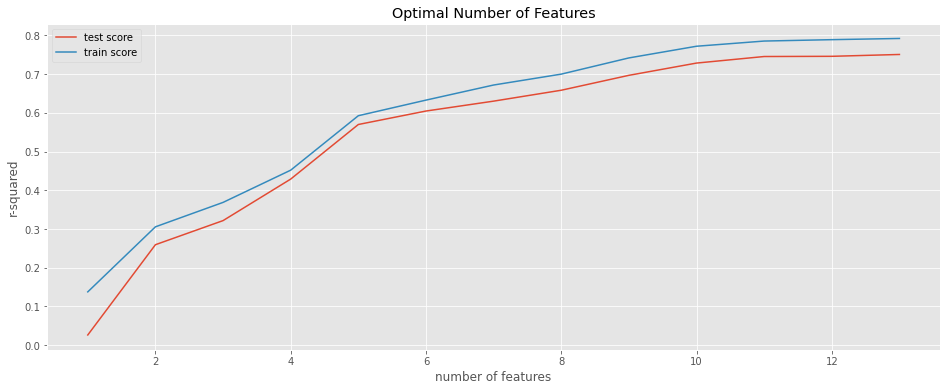

In [76]:
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

## Нормализация признаков
Казалось бы, чем больше коэффициент модели, тем сильнее признак влияет на предсказание.
​
Но давайте посмотрим на разброс признаков:

In [38]:
dff.describe()

,atemp,hum,windspeed(mph),windspeed(ms),cnt,season_2,season_3,season_4,yr_1,mnth_10,...,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,atemp_sq,hum_sq,windspeed(mph)_sq,windspeed(ms)_sq
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,23.717699,62.789406,12.762576,5.705220,4504.348837,0.251710,0.257182,0.243502,0.500684,0.084815,...,0.142271,0.142271,0.143639,0.683995,0.337893,0.028728,628.829309,4145.092503,189.807044,37.929783
std,8.148059,14.242910,5.192357,2.321125,1937.211452,0.434293,0.437380,0.429489,0.500342,0.278797,...,0.349567,0.349567,0.350963,0.465233,0.473316,0.167155,383.586687,1796.618284,155.354933,31.045101
min,3.953480,0.000000,1.500244,0.670650,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.630004,0.000000,2.250732,0.449771
25%,16.892125,52.000000,9.041650,4.041864,3152.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,285.343910,2704.000000,81.751435,16.336665
50%,24.336650,62.666700,12.125325,5.420351,4548.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,592.272533,3927.115289,147.023506,29.380204
75%,30.430100,73.020850,15.625371,6.984967,5956.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,925.991969,5332.044969,244.152235,48.789766
max,42.044800,97.250000,34.000021,15.198937,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1767.765207,9457.562500,1156.001428,231.007671


И тогда понятно, почему у некоторых признаков коэффициент может оказаться сильно меньше, чем у других. Потому что модели приходится с помощью коэффициентов приводить значения к одной шкале.

Хорошим тоном является нормализация всех признаков. Например, можно привести значения каждого столбца к шкале $[0..1]$ с помощью следующего преобразования:
$$
\frac{x - min(x)}{max(x)}
$$

Сделать это можно как ручками, так и с помощью питона:

In [77]:
from sklearn.preprocessing import MinMaxScaler

# Создаём инструмент для нормализации признаков.
min_max_scaler = MinMaxScaler()
# Преобразуем признаки (на выходе будет np.ndarray).
X_scaled = min_max_scaler.fit_transform(X)
# Преобразуем np.ndarray обратно в pandas таблицу для удобства.
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

,atemp,hum,windspeed(ms),season_2,season_3,season_4,yr_1,mnth_10,mnth_11,mnth_12,...,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,atemp_sq,hum_sq,windspeed(ms)_sq,super_nice_day
0,0.373517,0.828620,0.284606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.179739,0.686611,0.098209,0.0
1,0.360541,0.715771,0.466215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.169621,0.512328,0.238390,0.0
2,0.144830,0.449638,0.465740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.042266,0.202174,0.237945,0.0
3,0.174649,0.607131,0.284297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.055281,0.368608,0.098022,0.0
4,0.197158,0.449313,0.339143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.066080,0.201882,0.133961,0.0


Теперь попробуйте снова обучить модель и посмотреть, есть ли различия:

In [78]:
lr = LinearRegression()
lr.fit(X_scaled, y)

LinearRegression()

In [82]:
np.abs(lr.coef_)

array([1.36987852e+04, 5.04147406e+03, 2.61917308e+02, 8.39802263e+02,
       1.02330333e+03, 1.56430807e+03, 1.95974431e+03, 1.56620470e+01,
       6.25931100e+02, 4.77537441e+02, 1.39010097e+02, 1.58373861e+02,
       2.19664956e+01, 4.71002289e+02, 4.88273797e+02, 3.11423103e+02,
       4.12443719e+02, 6.71552154e+02, 1.72189110e+02, 1.31049207e+02,
       4.93728467e-01, 5.56115873e+01, 8.42795881e+01, 1.17100785e+02,
       4.43524821e+02, 2.98625593e+02, 4.60762893e+02, 1.53192842e+03,
       1.06545201e+04, 5.51627174e+03, 1.80179360e+03, 2.86836560e+02])